## Importing libraries

In [62]:
import csv
import re
import os
import emoji
import matplotlib.pyplot as plt
from tabulate import tabulate
import textwrap
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, classification_report
import pandas as pd
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns

## Analyzing the dataset

The dataset is made of 2 files:
- raw_test_data.tsv
- raw_training_data.tsv

Let's start analyzing the training one:

## Training set

In [63]:
def read_set(input_set):
    data = []
    with open(input_set, 'r', encoding='utf-8') as tsv_file:
        tsv_reader = csv.reader(tsv_file, delimiter='\t')
        next(tsv_reader)  # Salta l'intestazione del file

        # Legge le righe del file e salva le features e le labels come dizionari
        for row in tsv_reader:
            sample = {}
            sample['text'] = row[1]
            sample['misogynous'] = int(row[2])
            sample['aggressiveness'] = int(row[3])

            data.append(sample)
    return data

train_set = read_set("Datasets/raw_training_data.tsv")
train_tweets_number = len(train_set)
train_m_tweets_number = len([sample['text'] for sample in train_set if sample['misogynous'] == 1])
train_a_tweets_number = len([sample['text'] for sample in train_set if sample['aggressiveness'] == 1])
print("Number of tweets in the set:", train_tweets_number)
print("Number of misogynistic tweets in the set:", train_m_tweets_number)
print("Number of misogynistic and aggressive tweets in the set:", train_a_tweets_number)

Number of tweets in the set: 4998
Number of misogynistic tweets in the set: 2337
Number of misogynistic and aggressive tweets in the set: 1783


## Plotting the distribution to better visualize the training set

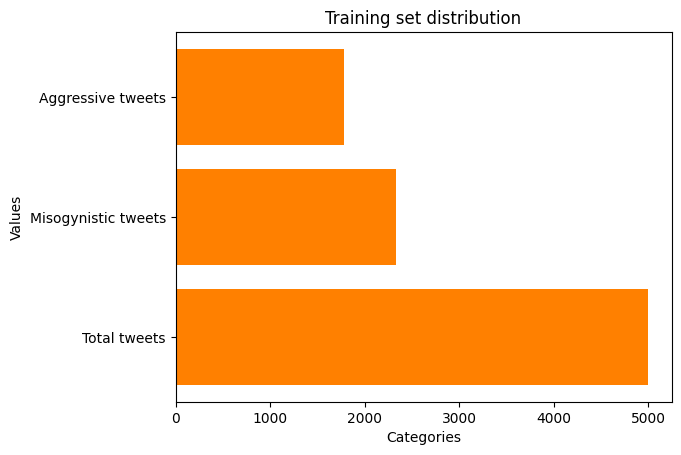

In [64]:
categories = ["Total tweets", "Misogynistic tweets", "Aggressive tweets"]
values = [train_tweets_number, train_m_tweets_number, train_a_tweets_number]
# Creazione del grafico a barre
plt.barh(categories, values, color='#FF8000')

# Aggiunta di etichette agli assi
plt.xlabel('Categories')
plt.ylabel('Values')

# Aggiunta di un titolo al grafico
plt.title('Training set distribution')

# Mostra il grafico
plt.show()

## Test set

In [65]:
test_set = read_set("Datasets/raw_test_data.tsv")
tweets_number = len(test_set)
m_tweets_number = len([sample['text'] for sample in test_set if sample['misogynous'] == 1])
a_tweets_number = len([sample['text'] for sample in test_set if sample['aggressiveness'] == 1])
print("Number of tweets in the set:", tweets_number)
print("Number of misogynistic tweets in the set:", m_tweets_number)
print("Number of misogynistic and aggressive tweets in the set:", a_tweets_number)


Number of tweets in the set: 1000
Number of misogynistic tweets in the set: 500
Number of misogynistic and aggressive tweets in the set: 176


## Plotting the distribution to better visualize the test set

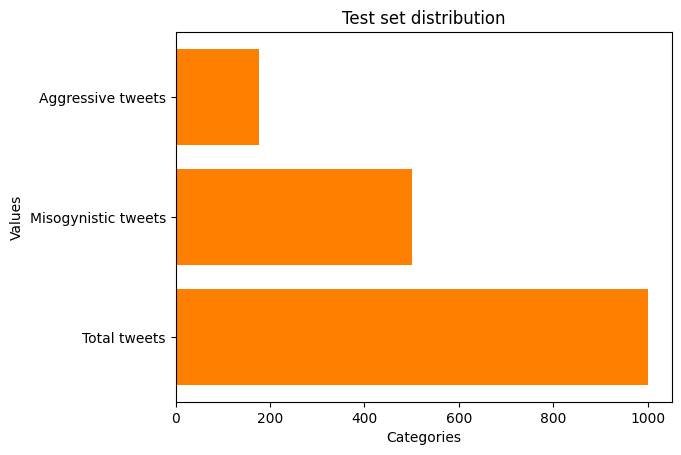

In [66]:
categories = ["Total tweets", "Misogynistic tweets", "Aggressive tweets"]
values = [tweets_number, m_tweets_number, a_tweets_number]
# Creazione del grafico a barre
plt.barh(categories, values, color='#FF8000')

# Aggiunta di etichette agli assi
plt.xlabel('Categories')
plt.ylabel('Values')

# Aggiunta di un titolo al grafico
plt.title('Test set distribution')

# Mostra il grafico
plt.show()

## Examples of tweets in the training set

In [67]:
sample_data = train_set[:5]

table_data = []
for sample in sample_data:
    wrapped_text = textwrap.shorten(sample['text'], width=80, placeholder="...")
    table_data.append([wrapped_text, sample['misogynous'], sample['aggressiveness']])

headers = ["Text", "Misogynous", "Aggressiveness"]
print("First 5 tweets of the training set:")
print(tabulate(table_data, headers=headers, tablefmt="fancy_grid"))

First 5 tweets of the training set:
╒═════════════════════════════════════════════════════════════════════════════════╤══════════════╤══════════════════╕
│ Text                                                                            │   Misogynous │   Aggressiveness │
╞═════════════════════════════════════════════════════════════════════════════════╪══════════════╪══════════════════╡
│ <MENTION_1> <MENTION_2> Fatti trovare te lo do volentieri e ti sborro in bocca  │            1 │                1 │
├─────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────────┤
│ <MENTION_1> Tu dovresti ricominciare dai semafori a fare la lavavetri..ma...    │            1 │                1 │
├─────────────────────────────────────────────────────────────────────────────────┼──────────────┼──────────────────┤
│ Amore,sei presentabile? Xchè così via Skype ti faccio conoscere i miei...       │            1 │                1 │
├───────────────────

## Data Pre-Processing

As a first operation we are going to clean the dataset from all the <MENTION_X> and \<URL> strings to improve the training and test sets


In [68]:

input_train_file = "Datasets/raw_training_data.tsv"
input_test_file = "Datasets/raw_test_data.tsv"

output_folder = "OutputDatasets"
output_train_file = "raw_training_data.tsv"
output_test_file = "raw_test_data.tsv"

pattern = r"<(MENTION_\d+|URL)>\s*"

def remove_mention(input_file, output_file, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_file = os.path.join(output_folder, output_file)
    with open(input_file, "r", newline="", encoding="utf-8") as file_in, open(output_file, "w", newline="", encoding="utf-8") as file_out:
        reader = csv.reader(file_in, delimiter="\t")
        writer = csv.writer(file_out, delimiter="\t")

        for row in reader:
            modified_row = [re.sub(pattern, "", cell) for cell in row]
            writer.writerow(modified_row)

remove_mention(input_train_file, output_train_file, output_folder)
remove_mention(input_test_file, output_test_file, output_folder)

We have notice the presence of emojis in the dataset.
The emojis must be removed because they are useless and disturbing elements during the execution of the task.

In [69]:
input_train_file = "OutputDatasets/raw_training_data.tsv"
input_test_file = "OutputDatasets/raw_test_data.tsv"

output_folder = "OutputDatasetsNoEmoji"
output_train_file = "raw_training_data.tsv"
output_test_file = "raw_test_data.tsv"

def get_emoji_regexp():
    emojis = sorted(emoji.EMOJI_DATA, key=len, reverse=True)
    pattern = u'(' + u'|'.join(re.escape(u) for u in emojis) + u')'
    return re.compile(pattern)

def remove_emoji(string):
    cleaned = re.sub(get_emoji_regexp(), "", string)
    return cleaned.strip()

def remove_emoji_from_tsv(input_file, output_file, output_folder):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    output_file = os.path.join(output_folder, output_file)
    with open(input_file, "r", newline="", encoding="utf-8") as file_in, open(output_file, "w", newline="", encoding="utf-8") as file_out:
        reader = csv.reader(file_in, delimiter="\t")
        writer = csv.writer(file_out, delimiter="\t")
        for row in reader:
            modified_row = [remove_emoji(cell) for cell in row]
            writer.writerow(modified_row)

remove_emoji_from_tsv(input_train_file, output_train_file, output_folder)
remove_emoji_from_tsv(input_test_file, output_test_file, output_folder)


Both the training set and the test set have been cleaned. This are samples of before and after for the training set:

In [70]:
input_train_file = "OutputDatasetsNoEmoji/raw_training_data.tsv"
input_test_file = "OutputDatasetsNoEmoji/raw_test_data.tsv"

train_set_cleaned = read_set(input_train_file)
test_set_cleaned = read_set(input_test_file)

print("Pre-cleaning:")
for x in range(5):
    print("Tweet ",str(x),": ",train_set[x]['text'])

print("Post-cleaning:")
for x in range(5):
    print("Tweet ",str(x),": ",train_set_cleaned[x]['text'])

Pre-cleaning:
Tweet  0 :  <MENTION_1> <MENTION_2> Fatti trovare  te lo do volentieri e ti sborro in bocca
Tweet  1 :  <MENTION_1> Tu dovresti ricominciare dai semafori a fare la lavavetri..ma tranquilla tanto il vitalizio ti resterà in gola
Tweet  2 :  Amore,sei presentabile? Xchè così via Skype ti faccio conoscere i miei parenti..." e fu così che da un tablet ho conosciuto i parenti terroni della mia tettona,prendendomi un "avete già finito di pranzare? beh si,voi al nord siete diversi..." Dal nord è tutto,a voi..."
Tweet  3 :  <MENTION_1> Salvo poi mandare la culona a Mosca, aummaumm, per farsi dare da Putin commesse multimiliardarie e metterlo in quel posto ai FRATELLI della UE (tra i quali NOI)
Tweet  4 :  <MENTION_1> <MENTION_2> Vediamo Gentiloni, è ora di finirla di essere servili! Pensiamo al danno che la Francia ci ha fatto con Sarkosy e la culona della Merkel con il bombardamento della Libia
Post-cleaning:
Tweet  0 :  Fatti trovare  te lo do volentieri e ti sborro in bocca
Twe

## Dividing the training set and the test set

In this part we prepare the different sets for the subtasks.
- train_set_miso: contains all the data for the train for the task of finding misogynous tweets
- test_set_miso: contains all the data for the test for the task of finding misogynous tweets
- train_set_aggr: contains all the data for the train for the task of finding aggressive tweets among misogynistic ones
- test_set_aggr: contains all the data for the test for the task of finding aggressive tweets among misogynistic ones

In [71]:
def miso_set(input_set):
    data = []
    for sample in input_set:
        new_data = {}
        new_data['text'] = sample['text']
        new_data['label'] = sample['misogynous']
        data.append(new_data)
    return data

def aggr_set(input_set):
    data = []
    for sample in input_set:
        if sample['misogynous'] == 1:
            new_data = {}
            new_data['text'] = sample['text']
            new_data['label'] = sample['aggressiveness']
            data.append(new_data)
    return data


train_set_miso = miso_set(train_set_cleaned)
test_set_miso = miso_set(test_set_cleaned)


train_set_aggr = aggr_set(train_set_cleaned)
test_set_aggr = aggr_set(test_set_cleaned)


## Random Forest

We have decided to start with a simple model to test the result of this task

In [72]:

# This is the custom function to apply different nlp operations on the text
def custom_no_stem_tokenizer(text):
    tokens = text.lower().split()
    tokens = [token.strip(string.punctuation) for token in tokens]
    stopwords_list = set(stopwords.words('italian'))
    tokens = [token for token in tokens if token not in stopwords_list]
    tokens = [token for token in tokens if token]
    return tokens

def custom_tokenizer(text):
    tokens = text.lower().split()
    tokens = [token.strip(string.punctuation) for token in tokens]
    stopwords_list = set(stopwords.words('italian'))
    tokens = [token for token in tokens if token not in stopwords_list]
    stemmer = SnowballStemmer('italian')
    tokens = [stemmer.stem(token) for token in tokens]
    tokens = [token for token in tokens if token]
    return tokens

def test_random_forest(vectorizer,train_set_miso,test_set_miso):
    train_features = vectorizer.fit_transform(train_set_miso["text"])
    test_features = vectorizer.transform(test_set_miso["text"])

    rf_model = RandomForestClassifier()
    rf_model.fit(train_features, train_set_miso["label"])

    predictions = rf_model.predict(test_features)

    f1 = f1_score(test_set_miso["label"], predictions)
    print("F1 score:", f"{f1:.4f}")

    classification_rep = classification_report(test_set_miso["label"], predictions)
    print("Report di classificazione:\n", classification_rep)

    return f1,predictions



# Misogyny Detection

In [86]:
train_set_miso_rf = pd.DataFrame(train_set_miso)
test_set_miso_rf = pd.DataFrame(test_set_miso)

vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1,predictions = test_random_forest(vectorizer,train_set_miso_rf,test_set_miso_rf)


C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7104
Report di classificazione:
               precision    recall  f1-score   support

           0       0.78      0.39      0.52       500
           1       0.59      0.89      0.71       500

    accuracy                           0.64      1000
   macro avg       0.68      0.64      0.61      1000
weighted avg       0.68      0.64      0.61      1000



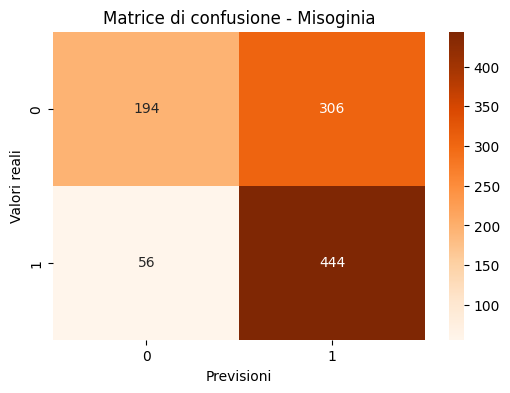

In [87]:
# Convert the test_set_miso and predictions to DataFrames
predictions_df = pd.DataFrame(predictions, columns=["predicted_label"])

# misogenia confusion matrix
cm_miso = confusion_matrix(test_set_miso_rf["label"], predictions_df["predicted_label"])
plt.figure(figsize=(6, 4))
sns.heatmap(cm_miso, annot=True, fmt="d", cmap="Oranges")
plt.title("Confusion Matrix - Misogeny")
plt.xlabel("Previsions")
plt.ylabel("Real values")
plt.show()

- True Negative (TN): The number of correctly predicted negative instances (non-misogynous) is 194.
- False Positive (FP): The number of incorrectly predicted positive instances (misogynous) is 306.
- False Negative (FN): The number of incorrectly predicted negative instances (non-misogynous) is 56.
- True Positive (TP): The number of correctly predicted positive instances (misogynous) is 444.

Looking at the results we can see that the random forest has some difficults with the class 0, having a really low recall, so we decided to do some modifications to the texts in input, starting with the stemming operation.

In [75]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_rf_miso,predictions = test_random_forest(vectorizer,train_set_miso_rf,test_set_miso_rf)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7197
Report di classificazione:
               precision    recall  f1-score   support

           0       0.77      0.47      0.58       500
           1       0.62      0.86      0.72       500

    accuracy                           0.67      1000
   macro avg       0.69      0.67      0.65      1000
weighted avg       0.69      0.67      0.65      1000



We can see that overall the result has improved, but as aspected each class slightly improved as result of the stemming operation.

# Aggressive detection

In [76]:
train_set_aggr_rf = pd.DataFrame(train_set_aggr)
test_set_aggr_rf = pd.DataFrame(test_set_aggr)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1,predictions = test_random_forest(vectorizer,train_set_aggr_rf,test_set_aggr_rf)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.5846
Report di classificazione:
               precision    recall  f1-score   support

           0       0.87      0.35      0.50       324
           1       0.43      0.90      0.58       176

    accuracy                           0.55       500
   macro avg       0.65      0.63      0.54       500
weighted avg       0.72      0.55      0.53       500



- Looking at this results we can clearly see that the performance are even worse than the misogyny detection probably because the set is not balaced (there are a lot of tweets that are not aggressive in the training set).
- As starting test we try to artificially reduce the number of tweets in the training set that are aggressive, in this way the classes are more balanced.

In [77]:
new_train = []
cont = 1400
for sample in train_set_aggr:
    new_data = {}
    if sample['label'] == 1:
        if cont == 0:
            new_data['text'] = sample['text']
            new_data['label'] = sample['label']
            new_train.append(new_data)
        else:
            cont-=1
    else:
        new_data['text'] = sample['text']
        new_data['label'] = sample['label']
        new_train.append(new_data)     

new_train = pd.DataFrame(new_train)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_rf_aggr,predictions = test_random_forest(vectorizer,new_train,test_set_aggr_rf)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.6260
Report di classificazione:
               precision    recall  f1-score   support

           0       0.80      0.78      0.79       324
           1       0.61      0.64      0.63       176

    accuracy                           0.73       500
   macro avg       0.71      0.71      0.71       500
weighted avg       0.73      0.73      0.73       500



- As we can see the result of the class 0 and class 1 are more balanced. Looking at this result we can discuss the misogyny detection ones. 
- Here the random forest has much less trouble distinguishing the aggressive misogyny tweet to a non-aggressive one. The reason for the low recall during the misogyny detection could a lack of effective representation of non-misogynistic phrases in the training dataset and as a result the model does not perform well when recognizing class 0

**Random Forest $score_A$**

In [78]:
print("Score A for the random forest:")
score = (f1_rf_miso + f1_rf_aggr)/2
print(f"{score:.4f}")

Score A for the random forest:
0.6729


## Naive Bayes

In [79]:
from sklearn.naive_bayes import MultinomialNB

def test_naive_bayes(vectorizer, train_set, test_set):
    train_features = vectorizer.fit_transform(train_set["text"])
    test_features = vectorizer.transform(test_set["text"])

    nb_model = MultinomialNB()
    nb_model.fit(train_features, train_set["label"])

    predictions = nb_model.predict(test_features)

    f1 = f1_score(test_set["label"], predictions)
    print("F1 score:", f"{f1:.4f}")

    classification_rep = classification_report(test_set["label"], predictions)
    print("Report di classificazione:\n", classification_rep)

    return f1, predictions

In [80]:
train_set_miso_nb = pd.DataFrame(train_set_miso)
test_set_miso_nb = pd.DataFrame(test_set_miso)

train_set_aggr_nb = pd.DataFrame(train_set_aggr)
test_set_aggr_nb = pd.DataFrame(test_set_aggr)

In [81]:
# Esempio di utilizzo con il set di dati "train_set_miso_rf" e "test_set_miso_rf"
vectorizer = TfidfVectorizer(tokenizer=custom_no_stem_tokenizer)
f1_nb_miso,predictions = test_naive_bayes(vectorizer, train_set_miso_nb, test_set_miso_nb)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7595
Report di classificazione:
               precision    recall  f1-score   support

           0       0.75      0.79      0.77       500
           1       0.78      0.74      0.76       500

    accuracy                           0.77      1000
   macro avg       0.77      0.77      0.76      1000
weighted avg       0.77      0.77      0.76      1000



In [82]:
# Esempio di utilizzo con il set di dati "train_set_miso_rf" e "test_set_miso_rf"
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_aggr,predictions = test_naive_bayes(vectorizer, train_set_miso_nb, test_set_miso_nb)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.7646
Report di classificazione:
               precision    recall  f1-score   support

           0       0.75      0.84      0.79       500
           1       0.82      0.72      0.76       500

    accuracy                           0.78      1000
   macro avg       0.78      0.78      0.78      1000
weighted avg       0.78      0.78      0.78      1000



In [83]:
vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_new,predictions = test_naive_bayes(vectorizer, train_set_aggr_nb, test_set_aggr_nb)

C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.5207
Report di classificazione:
               precision    recall  f1-score   support

           0       0.00      0.00      0.00       324
           1       0.35      1.00      0.52       176

    accuracy                           0.35       500
   macro avg       0.18      0.50      0.26       500
weighted avg       0.12      0.35      0.18       500



C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1344

In [84]:
new_train = []
cont = 1400
for sample in train_set_aggr:
    new_data = {}
    if sample['label'] == 1:
        if cont == 0:
            new_data['text'] = sample['text']
            new_data['label'] = sample['label']
            new_train.append(new_data)
        else:
            cont -= 1
    else:
        new_data['text'] = sample['text']
        new_data['label'] = sample['label']
        new_train.append(new_data)

new_train = pd.DataFrame(new_train)

vectorizer = TfidfVectorizer(tokenizer=custom_tokenizer)
f1_nb_new,predictions = test_naive_bayes(vectorizer, new_train, test_set_aggr_nb)


C:\Users\Ferdo\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


F1 score: 0.6540
Report di classificazione:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80       324
           1       0.63      0.68      0.65       176

    accuracy                           0.75       500
   macro avg       0.72      0.73      0.73       500
weighted avg       0.75      0.75      0.75       500

